<a href="https://colab.research.google.com/github/AlexGordeev1661/BTCNewsSentimentPricePredictionModel/blob/main/ppm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TOOLS PREPARATION**

In [ ]:
# First of all, python modules and libraries used in this project need to be installed and imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


!pip install vaderSentiment
!pip install yfinance
!pip install pybit
!pip install ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.8 MB/s eta 0:00:00
  Created wheel for pybit: filename=pybit-5.9.0-py2.py3-none-any.whl size=39477 sha256=0daa8539beb05b0d7f5edcdee4187ccc5054f7357100f264e22eeeba4c27bc3c
  Stored in directory: /root/.cache/pip/wheels/a9/da/06/02dff0a8d1e494ab7a7c627337b5e58d18ae684ea52aef042f
Successfully built pybit
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=9f37d63077bdb55a6061b6bd66fd9bf3fc05b04a055a8ba7fdd6e7af2f22bad5
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


# **COLLECTING NEWS AND OTHER EXPLANATORY VARIABLES DATA**

In [ ]:
# prompt: How to adjust code to fetch all news articles and put them into a dataframe
from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup
import pandas as pd

# News data collection function
def get_google_news_articles(topics, start_date, end_date):
    all_articles = []

    for topic in topics:
        # Format start and end dates
        start_date_str = start_date.strftime('%Y-%m-%d')
        end_date_str = end_date.strftime('%Y-%m-%d')

        # Construct the URL with the specified topic and date range
        url = f"https://news.google.com/rss/search?q={topic}+after:{start_date_str}+before:{end_date_str}"

        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'xml')  # Parse XML content from the URL page
            articles = soup.find_all('item')
            # Find article name and date published for each article, combining them into one list called all_articles
            for article in articles:
                title = article.title.text
                pub_date = article.pubDate.text
                all_articles.append({'article': title, 'date_published': pub_date, 'topic': topic})
        else:
            print(f"Failed to fetch data from Google News for topic '{topic}'. Status code:", response.status_code)

    return all_articles

# Define start and end dates
start_date = datetime(2024, 12, 1)
end_date = datetime(2025, 3, 11)

# Define topics
topics = ['bitcoin']

df = pd.DataFrame() # Initialize a dataframe to store all articles

current_date = start_date
while current_date <= end_date:
    articles = get_google_news_articles(topics, current_date, current_date + timedelta(days=1))
    articles_df = pd.DataFrame(articles)
    df = pd.concat([df, articles_df], ignore_index=True)
    current_date += timedelta(days=1)

# Now 'all_articles_df' contains all the fetched articles
df


,article,date_published,topic
0,Japanese crypto service shuts down after theft...,"Mon, 02 Dec 2024 08:00:00 GMT",bitcoin
1,"Here's how bitcoin could hit $225,000: Analyst...","Mon, 02 Dec 2024 08:00:00 GMT",bitcoin
2,How Wall Street Powers MicroStrategy's Bitcoin...,"Mon, 02 Dec 2024 08:00:00 GMT",bitcoin
3,Is It Too Late to Buy Bitcoin? Analyzing the M...,"Mon, 02 Dec 2024 08:00:00 GMT",bitcoin
4,"MicroStrategy Buys More Bitcoin, Chairman Sayl...","Mon, 02 Dec 2024 08:00:00 GMT",bitcoin
...,...,...,...
8397,Bitcoin Recent Drop Feels Like 2017—Experts Pr...,"Wed, 12 Mar 2025 00:37:34 GMT",bitcoin
8398,Bitcoin and Crypto About To Be Boosted by Glob...,"Tue, 11 Mar 2025 19:55:33 GMT",bitcoin
8399,Bitcoin 'Heading Toward' $73K Amid Macro Headw...,"Tue, 11 Mar 2025 20:46:47 GMT",bitcoin
8400,Bitcoin Price Dumps but Losses Below February ...,"Wed, 12 Mar 2025 06:42:00 GMT",bitcoin


In [ ]:
# prompt: remove 'topic' column and delete everything after the "-" symbol in the article column

df = df.drop('topic', axis=1)

# Delete everything after the "-" symbol in the 'article' column
if 'article' in df.columns:
  df['article'] = df['article'].str.split('-').str[0]

df


,article,date_published
0,Japanese crypto service shuts down after theft...,"Mon, 02 Dec 2024 08:00:00 GMT"
1,"Here's how bitcoin could hit $225,000: Analyst","Mon, 02 Dec 2024 08:00:00 GMT"
2,How Wall Street Powers MicroStrategy's Bitcoin...,"Mon, 02 Dec 2024 08:00:00 GMT"
3,Is It Too Late to Buy Bitcoin? Analyzing the M...,"Mon, 02 Dec 2024 08:00:00 GMT"
4,"MicroStrategy Buys More Bitcoin, Chairman Sayl...","Mon, 02 Dec 2024 08:00:00 GMT"
...,...,...
8397,Bitcoin Recent Drop Feels Like 2017—Experts Pr...,"Wed, 12 Mar 2025 00:37:34 GMT"
8398,Bitcoin and Crypto About To Be Boosted by Glob...,"Tue, 11 Mar 2025 19:55:33 GMT"
8399,Bitcoin 'Heading Toward' $73K Amid Macro Headw...,"Tue, 11 Mar 2025 20:46:47 GMT"
8400,Bitcoin Price Dumps but Losses Below February ...,"Wed, 12 Mar 2025 06:42:00 GMT"


**CLEANING**

In [ ]:
import re

def cleaning(text):
  text = re.sub('[^A-Za-z]+', ' ', str(text))
  return text

df['cleaned_article'] = df['article'].apply(cleaning)
df.head()


,article,date_published,cleaned_article
0,Japanese crypto service shuts down after theft...,"Mon, 02 Dec 2024 08:00:00 GMT",Japanese crypto service shuts down after theft...
1,"Here's how bitcoin could hit $225,000: Analyst","Mon, 02 Dec 2024 08:00:00 GMT",Here s how bitcoin could hit Analyst
2,How Wall Street Powers MicroStrategy's Bitcoin...,"Mon, 02 Dec 2024 08:00:00 GMT",How Wall Street Powers MicroStrategy s Bitcoin...
3,Is It Too Late to Buy Bitcoin? Analyzing the M...,"Mon, 02 Dec 2024 08:00:00 GMT",Is It Too Late to Buy Bitcoin Analyzing the Ma...
4,"MicroStrategy Buys More Bitcoin, Chairman Sayl...","Mon, 02 Dec 2024 08:00:00 GMT",MicroStrategy Buys More Bitcoin Chairman Saylo...


**TOKENISATION**

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag

stop_words = set(stopwords.words('english'))

def process_text(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    filtered_tokens = [word for word, tag in tagged_tokens if word.lower() not in stop_words and word.isalpha()]
    return filtered_tokens

df['tokenized_article'] = df['cleaned_article'].apply(process_text)
df


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,article,date_published,cleaned_article,tokenized_article
0,Japanese crypto service shuts down after theft...,"Mon, 02 Dec 2024 08:00:00 GMT",Japanese crypto service shuts down after theft...,"[Japanese, crypto, service, shuts, theft, bitc..."
1,"Here's how bitcoin could hit $225,000: Analyst","Mon, 02 Dec 2024 08:00:00 GMT",Here s how bitcoin could hit Analyst,"[bitcoin, could, hit, Analyst]"
2,How Wall Street Powers MicroStrategy's Bitcoin...,"Mon, 02 Dec 2024 08:00:00 GMT",How Wall Street Powers MicroStrategy s Bitcoin...,"[Wall, Street, Powers, MicroStrategy, Bitcoin,..."
3,Is It Too Late to Buy Bitcoin? Analyzing the M...,"Mon, 02 Dec 2024 08:00:00 GMT",Is It Too Late to Buy Bitcoin Analyzing the Ma...,"[Late, Buy, Bitcoin, Analyzing, Market, Timing..."
4,"MicroStrategy Buys More Bitcoin, Chairman Sayl...","Mon, 02 Dec 2024 08:00:00 GMT",MicroStrategy Buys More Bitcoin Chairman Saylo...,"[MicroStrategy, Buys, Bitcoin, Chairman, Saylo..."
...,...,...,...,...
8397,Bitcoin Recent Drop Feels Like 2017—Experts Pr...,"Wed, 12 Mar 2025 00:37:34 GMT",Bitcoin Recent Drop Feels Like Experts Predict...,"[Bitcoin, Recent, Drop, Feels, Like, Experts, ..."
8398,Bitcoin and Crypto About To Be Boosted by Glob...,"Tue, 11 Mar 2025 19:55:33 GMT",Bitcoin and Crypto About To Be Boosted by Glob...,"[Bitcoin, Crypto, Boosted, Global, Money, Supp..."
8399,Bitcoin 'Heading Toward' $73K Amid Macro Headw...,"Tue, 11 Mar 2025 20:46:47 GMT",Bitcoin Heading Toward K Amid Macro Headwinds ...,"[Bitcoin, Heading, Toward, K, Amid, Macro, Hea..."
8400,Bitcoin Price Dumps but Losses Below February ...,"Wed, 12 Mar 2025 06:42:00 GMT",Bitcoin Price Dumps but Losses Below February ...,"[Bitcoin, Price, Dumps, Losses, February, Marc..."


In [ ]:
# prompt: How to keep the word 'up' as a token (and similar important words)?

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import re

# ... (Your existing code) ...

# **TOKENISATION**
nltk.download('punkt') # Use punkt instead of punkt_tab
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
# Customize stopwords to remove 'up' and similar words if needed
# stop_words.discard("up") # Example


def process_text(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    # Keep 'up' and other important words as tokens by modifying the filter condition
    filtered_tokens = [word for word, tag in tagged_tokens if word.lower() not in stop_words or word.lower() in ['up', 'down', 'increase', 'decrease']] # Example
    return filtered_tokens

df['tokenized_article'] = df['cleaned_article'].apply(process_text)
df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,article,date_published,cleaned_article,tokenized_article
0,Japanese crypto service shuts down after theft...,"Mon, 02 Dec 2024 08:00:00 GMT",Japanese crypto service shuts down after theft...,"[Japanese, crypto, service, shuts, down, theft..."
1,"Here's how bitcoin could hit $225,000: Analyst","Mon, 02 Dec 2024 08:00:00 GMT",Here s how bitcoin could hit Analyst,"[bitcoin, could, hit, Analyst]"
2,How Wall Street Powers MicroStrategy's Bitcoin...,"Mon, 02 Dec 2024 08:00:00 GMT",How Wall Street Powers MicroStrategy s Bitcoin...,"[Wall, Street, Powers, MicroStrategy, Bitcoin,..."
3,Is It Too Late to Buy Bitcoin? Analyzing the M...,"Mon, 02 Dec 2024 08:00:00 GMT",Is It Too Late to Buy Bitcoin Analyzing the Ma...,"[Late, Buy, Bitcoin, Analyzing, Market, Timing..."
4,"MicroStrategy Buys More Bitcoin, Chairman Sayl...","Mon, 02 Dec 2024 08:00:00 GMT",MicroStrategy Buys More Bitcoin Chairman Saylo...,"[MicroStrategy, Buys, Bitcoin, Chairman, Saylo..."
...,...,...,...,...
8397,Bitcoin Recent Drop Feels Like 2017—Experts Pr...,"Wed, 12 Mar 2025 00:37:34 GMT",Bitcoin Recent Drop Feels Like Experts Predict...,"[Bitcoin, Recent, Drop, Feels, Like, Experts, ..."
8398,Bitcoin and Crypto About To Be Boosted by Glob...,"Tue, 11 Mar 2025 19:55:33 GMT",Bitcoin and Crypto About To Be Boosted by Glob...,"[Bitcoin, Crypto, Boosted, Global, Money, Supp..."
8399,Bitcoin 'Heading Toward' $73K Amid Macro Headw...,"Tue, 11 Mar 2025 20:46:47 GMT",Bitcoin Heading Toward K Amid Macro Headwinds ...,"[Bitcoin, Heading, Toward, K, Amid, Macro, Hea..."
8400,Bitcoin Price Dumps but Losses Below February ...,"Wed, 12 Mar 2025 06:42:00 GMT",Bitcoin Price Dumps but Losses Below February ...,"[Bitcoin, Price, Dumps, Losses, February, Marc..."


**LEMMATISATION**

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_tokens(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    return lemmatized_tokens

df['lemmatized_article'] = df['tokenized_article'].apply(lemmatize_tokens)
df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,article,date_published,cleaned_article,tokenized_article,lemmatized_article
0,Japanese crypto service shuts down after theft...,"Mon, 02 Dec 2024 08:00:00 GMT",Japanese crypto service shuts down after theft...,"[Japanese, crypto, service, shuts, down, theft...","[Japanese, crypto, service, shuts, down, theft..."
1,"Here's how bitcoin could hit $225,000: Analyst","Mon, 02 Dec 2024 08:00:00 GMT",Here s how bitcoin could hit Analyst,"[bitcoin, could, hit, Analyst]","[bitcoin, could, hit, Analyst]"
2,How Wall Street Powers MicroStrategy's Bitcoin...,"Mon, 02 Dec 2024 08:00:00 GMT",How Wall Street Powers MicroStrategy s Bitcoin...,"[Wall, Street, Powers, MicroStrategy, Bitcoin,...","[Wall, Street, Powers, MicroStrategy, Bitcoin,..."
3,Is It Too Late to Buy Bitcoin? Analyzing the M...,"Mon, 02 Dec 2024 08:00:00 GMT",Is It Too Late to Buy Bitcoin Analyzing the Ma...,"[Late, Buy, Bitcoin, Analyzing, Market, Timing...","[Late, Buy, Bitcoin, Analyzing, Market, Timing..."
4,"MicroStrategy Buys More Bitcoin, Chairman Sayl...","Mon, 02 Dec 2024 08:00:00 GMT",MicroStrategy Buys More Bitcoin Chairman Saylo...,"[MicroStrategy, Buys, Bitcoin, Chairman, Saylo...","[MicroStrategy, Buys, Bitcoin, Chairman, Saylo..."
...,...,...,...,...,...
8397,Bitcoin Recent Drop Feels Like 2017—Experts Pr...,"Wed, 12 Mar 2025 00:37:34 GMT",Bitcoin Recent Drop Feels Like Experts Predict...,"[Bitcoin, Recent, Drop, Feels, Like, Experts, ...","[Bitcoin, Recent, Drop, Feels, Like, Experts, ..."
8398,Bitcoin and Crypto About To Be Boosted by Glob...,"Tue, 11 Mar 2025 19:55:33 GMT",Bitcoin and Crypto About To Be Boosted by Glob...,"[Bitcoin, Crypto, Boosted, Global, Money, Supp...","[Bitcoin, Crypto, Boosted, Global, Money, Supp..."
8399,Bitcoin 'Heading Toward' $73K Amid Macro Headw...,"Tue, 11 Mar 2025 20:46:47 GMT",Bitcoin Heading Toward K Amid Macro Headwinds ...,"[Bitcoin, Heading, Toward, K, Amid, Macro, Hea...","[Bitcoin, Heading, Toward, K, Amid, Macro, Hea..."
8400,Bitcoin Price Dumps but Losses Below February ...,"Wed, 12 Mar 2025 06:42:00 GMT",Bitcoin Price Dumps but Losses Below February ...,"[Bitcoin, Price, Dumps, Losses, February, Marc...","[Bitcoin, Price, Dumps, Losses, February, Marc..."


# **SENTIMENT ANALYSIS**

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(tokens):
    text = ' '.join(tokens)
    # Get polarity scores for the text
    scores = analyzer.polarity_scores(text)
    # Check if 'compound' key exists, if not, check for 'compound_score'
    compound_score = scores.get('compound', scores.get('compound_score', 0))
    return compound_score  # Return the compound score or 0 if not found

df['sentiment_scores'] = df['lemmatized_article'].apply(analyze_sentiment)


def vader_analysis(compound_score):
  if compound_score >= 0.5:
    return 'Positive'
  elif compound_score <= -0.5:
    return 'Negative'
  else:
    return 'Neutral'

df['Sentiment'] = df['sentiment_scores'].apply(vader_analysis)
df[['article', 'sentiment_scores', 'Sentiment']]

,article,sentiment_scores,Sentiment
0,Japanese crypto service shuts down after theft...,0.2263,Neutral
1,"Here's how bitcoin could hit $225,000: Analyst",0.0000,Neutral
2,How Wall Street Powers MicroStrategy's Bitcoin...,0.0000,Neutral
3,Is It Too Late to Buy Bitcoin? Analyzing the M...,0.0000,Neutral
4,"MicroStrategy Buys More Bitcoin, Chairman Sayl...",0.0000,Neutral
...,...,...,...
8397,Bitcoin Recent Drop Feels Like 2017—Experts Pr...,0.1027,Neutral
8398,Bitcoin and Crypto About To Be Boosted by Glob...,0.3612,Neutral
8399,Bitcoin 'Heading Toward' $73K Amid Macro Headw...,0.0000,Neutral
8400,Bitcoin Price Dumps but Losses Below February ...,-0.6597,Negative


In [ ]:
# prompt: combine df on the same values of the 'date_published' column and calculate average sentiment for each day (only day published is important, exclude GMT time)

import pandas as pd

# Assuming your DataFrame is named 'final_df'
# and the 'date_published' column is already in 'yyyy-mm-dd' format
final_df = df.copy()
# Convert 'date_published' to datetime objects if it's not already
final_df['date_published'] = pd.to_datetime(final_df['date_published'])

# Extract the date part (day)
final_df['date_only'] = final_df['date_published'].dt.date

# Group by the date part and calculate the average sentiment
daily_avg_sentiment = final_df.groupby('date_only')['sentiment_scores'].mean().reset_index()

# Rename the columns
daily_avg_sentiment.columns = ['date_published', 'Average Sentiment']

daily_avg_sentiment


,date_published,Average Sentiment
0,2024-12-01,0.164845
1,2024-12-02,0.075679
2,2024-12-03,-0.009973
3,2024-12-04,0.172488
4,2024-12-05,0.088524
...,...,...
97,2025-03-08,0.056351
98,2025-03-09,-0.002983
99,2025-03-10,-0.080234
100,2025-03-11,0.042971


#**BTC DATA**

In [ ]:
import yfinance as yf
import pandas as pd
import ta
from datetime import datetime

# Define the start and end dates
start_date = datetime(2024, 12, 1)
end_date = datetime(2025, 3, 13)

# Download the data
data = yf.download("BTC-USD", start=start_date, end=end_date)

# Create the dfBTC DataFrame
dfBTC = data.copy()
dfBTC.index.name = 'Date'
dfBTC = dfBTC.reset_index()
dfBTC.columns = ['date_published', 'Adj_Close', 'High', 'Low', 'Open', 'Volume']
# Display the DataFrame
dfBTC


[*********************100%***********************]  1 of 1 completed


,date_published,Adj_Close,High,Low,Open,Volume
0,2024-12-01,97279.789062,97888.125000,95770.187500,96461.335938,36590695296
1,2024-12-02,95865.304688,98152.601562,94482.867188,97276.007812,72680784305
2,2024-12-03,96002.164062,96297.203125,93629.562500,95854.593750,67067810961
3,2024-12-04,98768.531250,99207.328125,94660.523438,95988.531250,77199817112
4,2024-12-05,96593.570312,103900.468750,91998.781250,98741.539062,149218945580
...,...,...,...,...,...,...
96,2025-03-07,86742.671875,91191.046875,84717.679688,89963.281250,65945677657
97,2025-03-08,86154.593750,86847.265625,85247.484375,86742.656250,18206118081
98,2025-03-09,80601.039062,86471.132812,80052.484375,86154.304688,30899345977
99,2025-03-10,78532.000000,83955.929688,77420.593750,80597.148438,54061099422


In [ ]:
# prompt: Using dataframe dfBTC: Calculate RSI for the 'Close' column values

import pandas as pd
import numpy as np

# Function to calculate RSI
def calculate_rsi(data, window=14):
    # Calculate price differences
    delta = data.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate average gains and losses over the window
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Assuming your dataframe is called dfBTC and the 'Close' column is named as such.
# Calculate RSI for the 'Close' column
dfBTC['RSI'] = calculate_rsi(dfBTC['Adj_Close'])

dfBTC


,date_published,Adj_Close,High,Low,Open,Volume,RSI
0,2024-12-01,97279.789062,97888.125000,95770.187500,96461.335938,36590695296,NaN
1,2024-12-02,95865.304688,98152.601562,94482.867188,97276.007812,72680784305,NaN
2,2024-12-03,96002.164062,96297.203125,93629.562500,95854.593750,67067810961,NaN
3,2024-12-04,98768.531250,99207.328125,94660.523438,95988.531250,77199817112,NaN
4,2024-12-05,96593.570312,103900.468750,91998.781250,98741.539062,149218945580,NaN
...,...,...,...,...,...,...,...
96,2025-03-07,86742.671875,91191.046875,84717.679688,89963.281250,65945677657,38.232624
97,2025-03-08,86154.593750,86847.265625,85247.484375,86742.656250,18206118081,36.972360
98,2025-03-09,80601.039062,86471.132812,80052.484375,86154.304688,30899345977,32.683336
99,2025-03-10,78532.000000,83955.929688,77420.593750,80597.148438,54061099422,34.828034


In [ ]:
# prompt: Now, calculate MACD in the same way

# Calculate MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate short-term and long-term exponential moving averages (EMAs)
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()

    # Calculate MACD line
    macd_line = short_ema - long_ema

    # Calculate signal line
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

    # Calculate MACD histogram
    macd_histogram = macd_line - signal_line

    return macd_line, signal_line, macd_histogram

# Assuming your dataframe is called dfBTC and the 'Close' column is named as such.
dfBTC['MACD'], dfBTC['MACD_Signal'], dfBTC['MACD_Histogram'] = calculate_macd(dfBTC['Adj_Close'])
dfBTC

,date_published,Adj_Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,MACD_Histogram
0,2024-12-01,97279.789062,97888.125000,95770.187500,96461.335938,36590695296,NaN,0.000000,0.000000,0.000000
1,2024-12-02,95865.304688,98152.601562,94482.867188,97276.007812,72680784305,NaN,-112.836360,-22.567272,-90.269088
2,2024-12-03,96002.164062,96297.203125,93629.562500,95854.593750,67067810961,NaN,-189.037475,-55.861313,-133.176162
3,2024-12-04,98768.531250,99207.328125,94660.523438,95988.531250,77199817112,NaN,-25.906065,-49.870263,23.964198
4,2024-12-05,96593.570312,103900.468750,91998.781250,98741.539062,149218945580,NaN,-71.302488,-54.156708,-17.145780
...,...,...,...,...,...,...,...,...,...,...
96,2025-03-07,86742.671875,91191.046875,84717.679688,89963.281250,65945677657,38.232624,-2518.753591,-2570.088734,51.335143
97,2025-03-08,86154.593750,86847.265625,85247.484375,86742.656250,18206118081,36.972360,-2582.409332,-2572.552854,-9.856478
98,2025-03-09,80601.039062,86471.132812,80052.484375,86154.304688,30899345977,32.683336,-3045.871505,-2667.216584,-378.654921
99,2025-03-10,78532.000000,83955.929688,77420.593750,80597.148438,54061099422,34.828034,-3539.323656,-2841.637998,-697.685658


In [ ]:
# prompt: Using dataframe dfBTC: Visualise MACD lines, MACD histogram

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots and mention plot grid size
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                   vertical_spacing=0.03, subplot_titles=('BTC Price', 'MACD'),
                   row_width=[0.2, 0.7])

# Plot the closing price
fig.add_trace(go.Scatter(x=dfBTC['date_published'], y=dfBTC['Adj_Close'], name='Price'), row=1, col=1)

# Plot MACD, MACD signal and histogram
colors = ['royalblue', 'firebrick', 'grey']
for i, col in enumerate(['MACD', 'MACD_Signal', 'MACD_Histogram']):
    fig.add_trace(go.Scatter(x=dfBTC['date_published'], y=dfBTC[col], name=col, line=dict(color=colors[i])), row=2, col=1)

fig.update_layout(title_text="BTC MACD", height=800, width=1000)
fig.show()


In [ ]:
# prompt: Delete all data till the 1st of Jan 2025 from the 'dfBTC' dataframe and join it with 'daily_avg_sentiment' on 'date_published' column

import pandas as pd
# Convert 'date_published' column in dfBTC to datetime objects if it's not already
dfBTC['date_published'] = pd.to_datetime(dfBTC['date_published'])

# Delete data before 2025-01-01
dfBTC = dfBTC[dfBTC['date_published'] >= '2025-01-01']

# Ensure 'date_published' in daily_avg_sentiment is also datetime
daily_avg_sentiment['date_published'] = pd.to_datetime(daily_avg_sentiment['date_published'])

# Merge the two dataframes
merged_df = pd.merge(dfBTC, daily_avg_sentiment, on='date_published', how='left')
merged_df

,date_published,Adj_Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,MACD_Histogram,Average Sentiment
0,2025-01-01,94419.757812,94929.867188,92788.125000,93425.101562,24519888919,36.569318,-1422.438443,-872.610056,-549.828387,0.129224
1,2025-01-02,96886.875000,97739.820312,94201.570312,94416.289062,46009564411,48.551052,-1202.550922,-938.598229,-263.952693,0.134633
2,2025-01-03,98107.429688,98956.914062,96034.617188,96881.726562,35611391163,50.806156,-919.203905,-934.719364,15.515459,0.082111
3,2025-01-04,98236.226562,98734.429688,97562.976562,98106.992188,22342608078,52.363475,-676.458725,-883.067236,206.608511,0.181852
4,2025-01-05,98314.960938,98813.304688,97291.765625,98233.906250,20525254825,58.291410,-472.284020,-800.910593,328.626574,-0.129475
...,...,...,...,...,...,...,...,...,...,...,...
65,2025-03-07,86742.671875,91191.046875,84717.679688,89963.281250,65945677657,38.232624,-2518.753591,-2570.088734,51.335143,0.063372
66,2025-03-08,86154.593750,86847.265625,85247.484375,86742.656250,18206118081,36.972360,-2582.409332,-2572.552854,-9.856478,0.056351
67,2025-03-09,80601.039062,86471.132812,80052.484375,86154.304688,30899345977,32.683336,-3045.871505,-2667.216584,-378.654921,-0.002983
68,2025-03-10,78532.000000,83955.929688,77420.593750,80597.148438,54061099422,34.828034,-3539.323656,-2841.637998,-697.685658,-0.080234


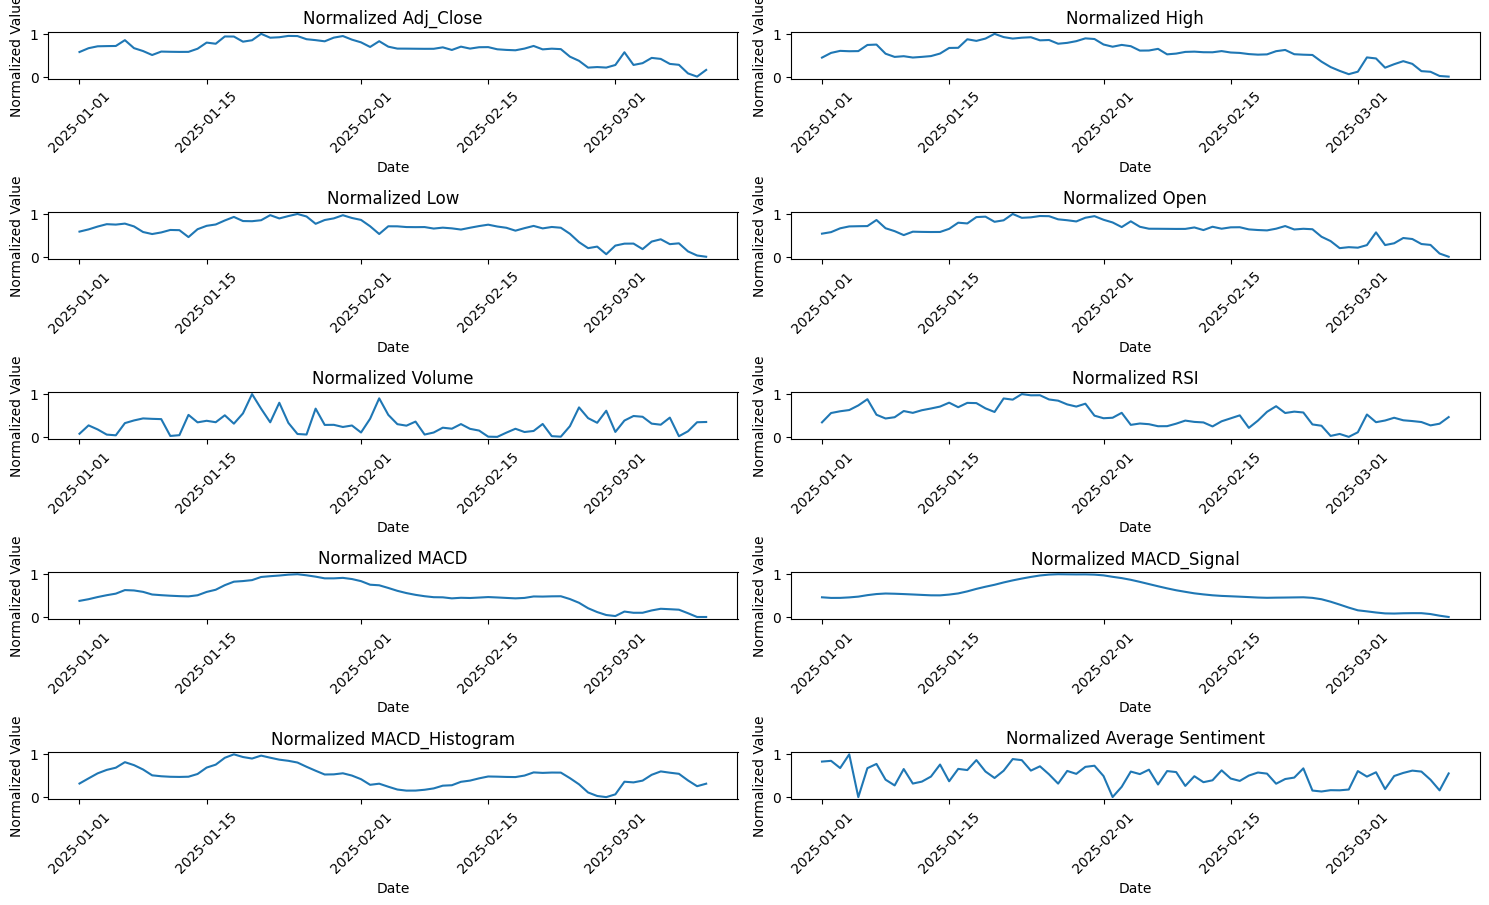

In [ ]:
# prompt: Normalise data using minmaxscaler and visualise variables

import matplotlib.pyplot as plt
# Assuming 'merged_df' is your DataFrame with the columns you want to normalize
# Select the columns to normalize
cols_to_normalize = ['Adj_Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'Average Sentiment']

# Create a MinMaxScaler object
scaler = MinMaxScaler()
initial_df = merged_df.copy()

# Fit the scaler to your data and then transform it
merged_df[cols_to_normalize] = scaler.fit_transform(merged_df[cols_to_normalize])

# Visualize the normalized variables
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

for i, col in enumerate(cols_to_normalize):
    plt.subplot(len(cols_to_normalize) // 2 + 1, 2, i + 1)  # Create subplots dynamically
    plt.plot(merged_df['date_published'], merged_df[col])
    plt.title(f'Normalized {col}')
    plt.xlabel('Date')
    plt.ylabel('Normalized Value')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout() # Adjusts subplot params for a tight layout

plt.show()


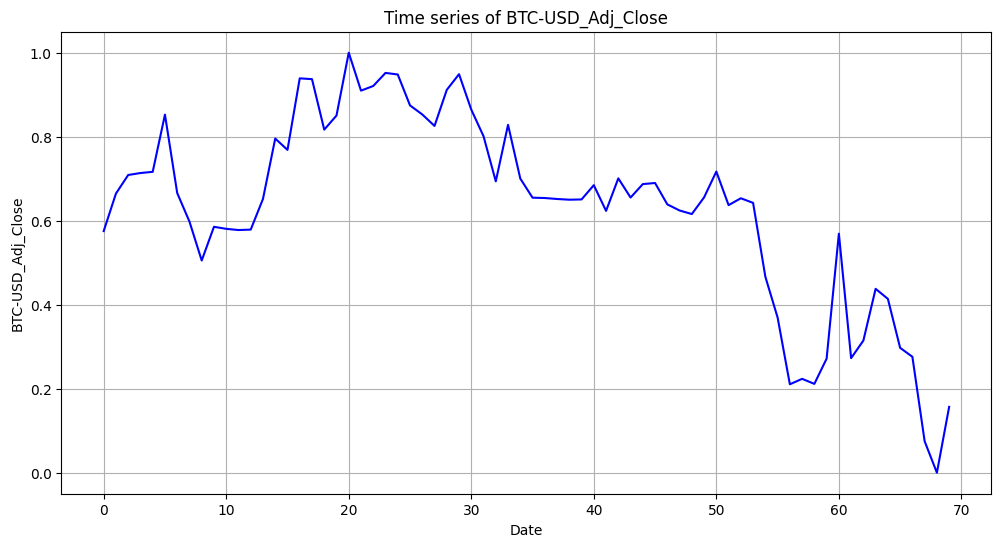

In [ ]:
# Plot the time series of 'BTC-USD_Adj_Close'
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['Adj_Close'], color='blue')
plt.title('Time series of BTC-USD_Adj_Close')
plt.xlabel('Date')
plt.ylabel('BTC-USD_Adj_Close')
plt.grid(True)
plt.show()

# **OUTLIERS DETECTION (MULTIVARIATE MODEL)**

In [ ]:
final_df=merged_df.copy()
final_df_nonscaled=final_df.drop(['date_published'], axis=1)
print(final_df_nonscaled.columns)

Index(['BTC-USD_Adj_Close', 'BTC-USD_Volume', 'RSI', 'MACD', 'MACD_Signal',
       'MACD_Histogram', 'Average Sentiment'],
      dtype='object')


In [ ]:
import numpy as np

# Outliers detection function
def detect_outliers_mahalanobis(df, threshold=3):
    # Calculate mean vector and covariance matrix
    mean_vector = np.mean(df, axis=0)
    covariance_matrix = np.cov(df, rowvar=False)

    # Calculate the inverse of the covariance matrix
    inv_covariance_matrix = np.linalg.inv(covariance_matrix)

    # Calculate Mahalanobis distance for each data point
    mahalanobis_dist = []
    for i in range(len(df)):
        x = df.iloc[i].values
        diff = x - mean_vector
        dist = np.sqrt(np.dot(np.dot(diff, inv_covariance_matrix), diff.T))
        mahalanobis_dist.append(dist)

    # Calculate the threshold value
    threshold_value = np.mean(mahalanobis_dist) + threshold * np.std(mahalanobis_dist)

    # Identify outliers
    outliers = df[mahalanobis_dist > threshold_value]

    return outliers

# Example usage:
outliers = detect_outliers_mahalanobis(final_df_nonscaled)
print("Outliers detected using Mahalanobis distance:")
print(outliers)


def replace_outliers_with_average(df, outliers):
    # Exclude the 'date_published' column from outlier replacement
    num_col = [col for col in df.columns if col != 'date_published']
    # Iterate over each column in the DataFrame
    for col in num_col:
        # Iterate over each row containing outliers
        for idx, row in outliers.iterrows():
            # Check if the current value is an outlier
            if row[col]:
                # Calculate the average of the previous and next values
                prev_value = df.at[idx - 1, col]
                next_value = df.at[idx + 1, col]
                average_value = (prev_value + next_value) / 2

                # Replace the outlier with the average value
                df.at[idx, col] = average_value
    return df


final_df1 = replace_outliers_with_average(final_df, outliers)

print(final_df1)

'''# Save DataFrame to CSV
csv_filename = 'etf_articles_avgsent_btc_nooutliers.csv'
final_df.to_csv(csv_filename, index=False)
print(f"CSV file with sentiment analysis and Bitcoin Adj Close data saved as: {csv_filename}")
'''

Outliers detected using Mahalanobis distance:
Empty DataFrame
Columns: [BTC-USD_Adj_Close, BTC-USD_Volume, RSI, MACD, MACD_Signal, MACD_Histogram, Average Sentiment]
Index: []
   date_published  BTC-USD_Adj_Close  BTC-USD_Volume       RSI      MACD  \
0      2025-01-01           0.575346        0.072744  0.339367  0.376888   
1      2025-01-02           0.664688        0.268562  0.557633  0.416021   
2      2025-01-03           0.708888        0.173812  0.598714  0.466448   
3      2025-01-04           0.713552        0.052904  0.627083  0.509649   
4      2025-01-05           0.716404        0.036344  0.735069  0.545986   
..            ...                ...             ...       ...       ...   
66     2025-03-08           0.276038        0.015212  0.346710  0.170451   
67     2025-03-09           0.074926        0.130875  0.268578  0.087969   
68     2025-03-10           0.000000        0.341930  0.307647  0.000150   
69     2025-03-11           0.156811        0.347777  0.462751  

'# Save DataFrame to CSV\ncsv_filename = \'etf_articles_avgsent_btc_nooutliers.csv\'\nfinal_df.to_csv(csv_filename, index=False)\nprint(f"CSV file with sentiment analysis and Bitcoin Adj Close data saved as: {csv_filename}")\n'

In [ ]:
from google.colab import files

# Save DataFrame to CSV
csv_filename = 'etf_articles_avgsent_btc_nooutliers.csv'
final_df.to_csv(csv_filename, index=False)
print(f"CSV file saved as: {csv_filename}")

# Download CSV file
files.download(csv_filename)

CSV file saved as: etf_articles_avgsent_btc_nooutliers.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

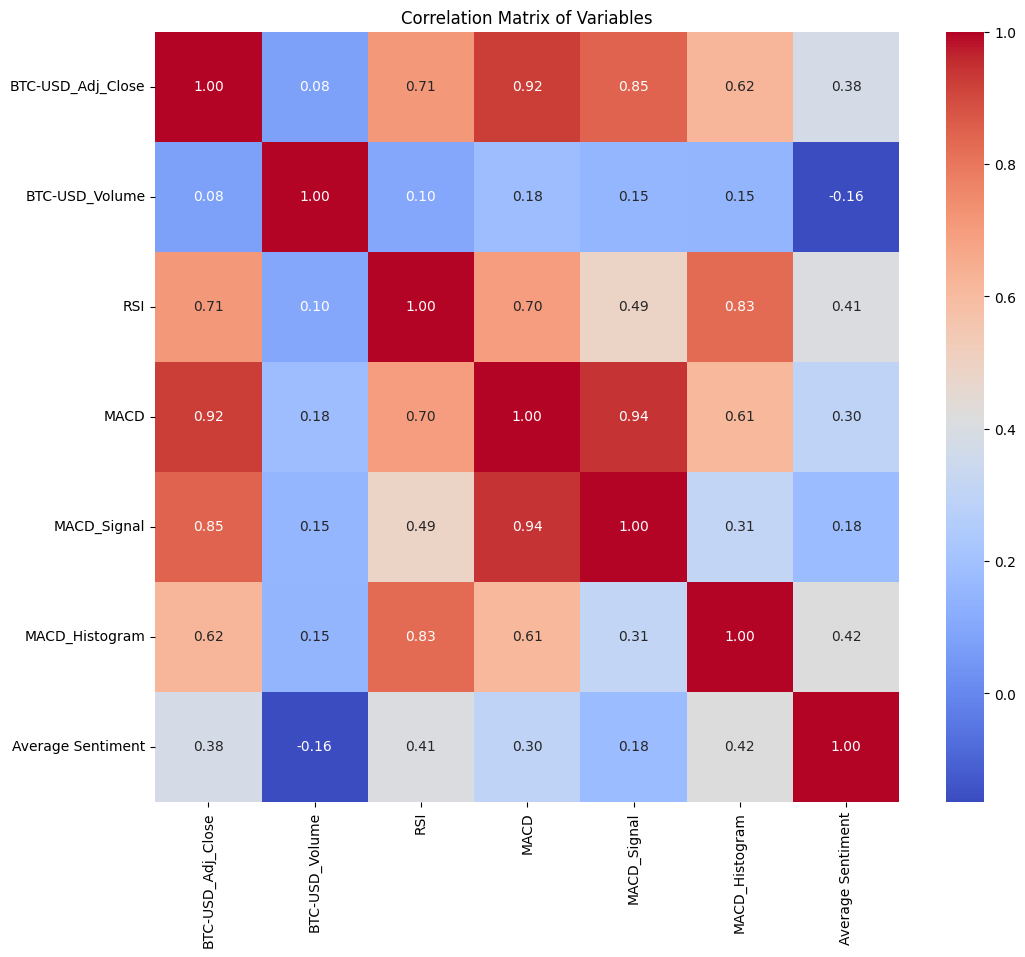

In [ ]:
# prompt: Check 'final_df_nonscaled' for autocorrelation and visualise the correlation matrix of variables

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'final_df_nonscaled' is your DataFrame

# Calculate the autocorrelation matrix
correlation_matrix = final_df_nonscaled.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()


In [ ]:
final_df

,date_published,BTC-USD_Adj_Close,BTC-USD_Volume,RSI,MACD,MACD_Signal,MACD_Histogram,Average Sentiment
0,2025-01-01,0.575346,0.072744,0.339367,0.376888,0.472427,0.317562,0.963384
1,2025-01-02,0.664688,0.268562,0.557633,0.416021,0.458341,0.438088,0.918340
2,2025-01-03,0.708888,0.173812,0.598714,0.466448,0.459169,0.555912,0.717627
3,2025-01-04,0.713552,0.052904,0.627083,0.509649,0.470195,0.636477,1.000000
4,2025-01-05,0.716404,0.036344,0.735069,0.545986,0.487733,0.687920,0.209159
...,...,...,...,...,...,...,...,...
66,2025-03-08,0.276038,0.015212,0.346710,0.170451,0.109542,0.545215,0.706314
67,2025-03-09,0.074926,0.130875,0.268578,0.087969,0.089334,0.389729,0.438606
68,2025-03-10,0.000000,0.341930,0.307647,0.000150,0.052100,0.255225,0.311340
69,2025-03-11,0.156811,0.347777,0.462751,0.000000,0.022278,0.313770,0.597113


# **LSTM MODEL**

In [ ]:
# prompt: Run the LSTM prediction model based on the final_df (that has already been scaled) time series dataframe with the value of 'BTC-USD_Adj_Close' as a predictor, calculate errors

import numpy as np
# Assuming 'final_df' is your DataFrame and 'BTC-USD_Adj_Close' is already scaled
# Prepare the data for LSTM
data = merged_df['Adj_Close'].values.reshape(-1, 1)
train_size = int(len(data) * 0.8)  # 80% for training, 20% for testing
train_data = data[:train_size]
test_data = data[train_size:]

# Function to create LSTM dataset
def create_dataset(dataset, look_back=1):
    trainX, trainY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        trainX.append(a)
        trainY.append(dataset[i + look_back, 0])
    return np.array(trainX), np.array(trainY)

look_back = 7  # Example lookback period
future = 1
num_of_features = 1

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape = (look_back, num_of_features)))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=50, batch_size=1, verbose=2)  # Adjust epochs and batch_size as needed

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to original scale
# Assuming 'scaler' is the same MinMaxScaler used for 'final_df'
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Y_train, train_predict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test, test_predict))
print('Test Score: %.2f RMSE' % (testScore))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



48/48 - 6s - 120ms/step - loss: 0.2055
Epoch 2/50
48/48 - 1s - 19ms/step - loss: 0.0174
Epoch 3/50
48/48 - 1s - 17ms/step - loss: 0.0143
Epoch 4/50
48/48 - 0s - 6ms/step - loss: 0.0133
Epoch 5/50
48/48 - 0s - 6ms/step - loss: 0.0123
Epoch 6/50
48/48 - 0s - 6ms/step - loss: 0.0130
Epoch 7/50
48/48 - 0s - 5ms/step - loss: 0.0135
Epoch 8/50
48/48 - 0s - 7ms/step - loss: 0.0132
Epoch 9/50
48/48 - 0s - 6ms/step - loss: 0.0125
Epoch 10/50
48/48 - 0s - 6ms/step - loss: 0.0160
Epoch 11/50
48/48 - 0s - 6ms/step - loss: 0.0123
Epoch 12/50
48/48 - 0s - 6ms/step - loss: 0.0135
Epoch 13/50
48/48 - 0s - 7ms/step - loss: 0.0127
Epoch 14/50
48/48 - 0s - 5ms/step - loss: 0.0135
Epoch 15/50
48/48 - 0s - 7ms/step - loss: 0.0121
Epoch 16/50
48/48 - 0s - 5ms/step - loss: 0.0123
Epoch 17/50
48/48 - 0s - 6ms/step - loss: 0.0144
Epoch 18/50
48/48 - 0s - 5ms/step - loss: 0.0112
Epoch 19/50
48/48 - 0s - 6ms/step - loss: 0.0139
Epoch 20/50
48/48 - 0s - 6ms/step - loss: 0.0121
Epoch 21/50
48/48 - 0s - 6ms/step - 

ValueError: non-broadcastable output operand with shape (48,1) doesn't match the broadcast shape (48,10)

In [ ]:
import numpy as np
# Assuming 'final_df' is your DataFrame and 'BTC-USD_Adj_Close' is already scaled
# Prepare the data for LSTM
data = merged_df['Adj_Close'].values.reshape(-1, 1)
train_size = int(len(data) * 0.8)  # 80% for training, 20% for testing
train_data = data[:train_size]
test_data = data[train_size:]

# Function to create LSTM dataset
def create_dataset(dataset, look_back=1):
    trainX, trainY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        trainX.append(a)
        trainY.append(dataset[i + look_back, 0])
    return np.array(trainX), np.array(trainY)

look_back = 7  # Example lookback period
future = 1
num_of_features = 1

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape = (look_back, num_of_features)))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, validation_split=0.30, epochs=50, batch_size=1, verbose=2)  # Adjust epochs and batch_size as needed

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to original scale
# Assuming 'scaler' is the same MinMaxScaler used for 'final_df'
# Create a dummy array with the same number of features as the original data
train_predict_extended = np.zeros((len(train_predict), merged_df.shape[1] -1 ))  # -1 to exclude the date column

# Put the predictions in the correct column (assuming 'Adj_Close' is the first column after date)
train_predict_extended[:, 0] = train_predict[:, 0]

# Now, inverse transform the extended predictions
train_predict = scaler.inverse_transform(train_predict_extended)[:, 0] # Get the predictions for the 'Adj_Close' column


# Repeat for test predictions:
test_predict_extended = np.zeros((len(test_predict), merged_df.shape[1] -1 ))
test_predict_extended[:, 0] = test_predict[:, 0]
test_predict = scaler.inverse_transform(test_predict_extended)[:, 0]

# Do the same for Y_train and Y_test if necessary:
Y_train_extended = np.zeros((len(Y_train), merged_df.shape[1] -1 ))
Y_train_extended[:, 0] = Y_train
Y_train = scaler.inverse_transform(Y_train_extended)[:, 0]

Y_test_extended = np.zeros((len(Y_test), merged_df.shape[1] -1 ))
Y_test_extended[:, 0] = Y_test
Y_test = scaler.inverse_transform(Y_test_extended)[:, 0]


# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Y_train, train_predict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test, test_predict))
print('Test Score: %.2f RMSE' % (testScore))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
33/33 - 5s - 141ms/step - loss: 0.2760 - val_loss: 0.0171
Epoch 2/50
33/33 - 0s - 11ms/step - loss: 0.0221 - val_loss: 0.0045
Epoch 3/50
33/33 - 1s - 16ms/step - loss: 0.0169 - val_loss: 0.0060
Epoch 4/50
33/33 - 0s - 8ms/step - loss: 0.0227 - val_loss: 0.0060
Epoch 5/50
33/33 - 0s - 8ms/step - loss: 0.0166 - val_loss: 0.0047
Epoch 6/50
33/33 - 0s - 9ms/step - loss: 0.0203 - val_loss: 0.0082
Epoch 7/50
33/33 - 0s - 8ms/step - loss: 0.0173 - val_loss: 0.0094
Epoch 8/50
33/33 - 0s - 9ms/step - loss: 0.0169 - val_loss: 0.0049
Epoch 9/50
33/33 - 0s - 8ms/step - loss: 0.0166 - val_loss: 0.0072
Epoch 10/50
33/33 - 0s - 9ms/step - loss: 0.0155 - val_loss: 0.0031
Epoch 11/50
33/33 - 0s - 8ms/step - loss: 0.0194 - val_loss: 0.0060
Epoch 12/50
33/33 - 0s - 10ms/step - loss: 0.0163 - val_loss: 0.0051
Epoch 13/50
33/33 - 0s - 9ms/step - loss: 0.0160 - val_loss: 0.0105
Epoch 14/50
33/33 - 0s - 8ms/step - loss: 0.0145 - val_loss: 0.0065
Epoch 15/50
33/33 - 0s - 8ms/step - loss: 0.0153 - v

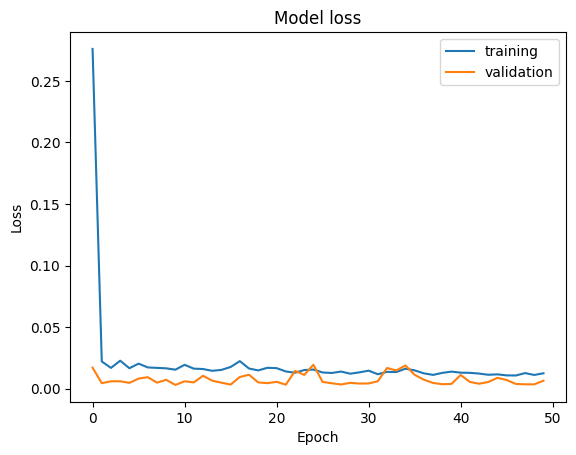

In [ ]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

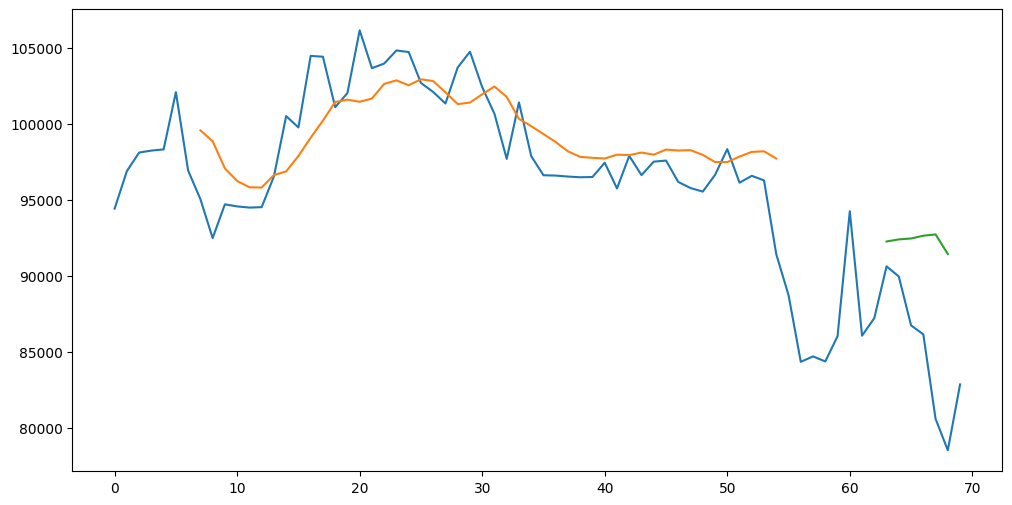

In [ ]:
# prompt: Do a prediction for 'Adj_Close' value and visualise in on a plot

import matplotlib.pyplot as plt
import numpy as np
# Shift train predictions for plotting
look_back=7
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
# Reshape train_predict to match trainPredictPlot
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict.reshape(-1, 1) # Reshape to (48, 1)

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
# Reshape test_predict to match testPredictPlot
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict.reshape(-1, 1)  # Reshape to (6, 1)

# Plot baseline and predictions
plt.figure(figsize=(12,6))
# The line below caused the error, because 'data' has a shape of (70, 1), but the scaler was fitted to 10 features.
#plt.plot(scaler.inverse_transform(data))
# Instead, we should inverse transform the original data that was used to fit the scaler.
plt.plot(initial_df['Adj_Close']) # Assuming 'initial_df' contains the original 'Adj_Close' values
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


#**TRADE** **STREAM**

In [ ]:
from pybit.unified_trading import HTTP

from pybit.unified_trading import WebSocket
from time import sleep
ws = WebSocket(
    testnet=False,
    channel_type="linear",
)
def handle_message(message):
    print(message)
ws.trade_stream(
    symbol="XRPUSDT",
    callback=handle_message
)
while True:
    sleep(1)

{'topic': 'publicTrade.XRPUSDT', 'type': 'snapshot', 'ts': 1741807803336, 'data': [{'T': 1741807803335, 's': 'XRPUSDT', 'S': 'Sell', 'v': '30', 'p': '2.2430', 'L': 'MinusTick', 'i': '44c89a15-0c70-59fe-81ef-513585411784', 'BT': False}]}
{'topic': 'publicTrade.XRPUSDT', 'type': 'snapshot', 'ts': 1741807803582, 'data': [{'T': 1741807803581, 's': 'XRPUSDT', 'S': 'Buy', 'v': '3', 'p': '2.2432', 'L': 'PlusTick', 'i': 'dae23e28-dd09-5f3b-a49f-965aaef82f92', 'BT': False}]}
{'topic': 'publicTrade.XRPUSDT', 'type': 'snapshot', 'ts': 1741807804614, 'data': [{'T': 1741807804613, 's': 'XRPUSDT', 'S': 'Buy', 'v': '5', 'p': '2.2433', 'L': 'PlusTick', 'i': 'b3134486-202a-5414-be34-4a42189c01c5', 'BT': False}, {'T': 1741807804613, 's': 'XRPUSDT', 'S': 'Buy', 'v': '20', 'p': '2.2433', 'L': 'ZeroPlusTick', 'i': 'c7cce518-1dd5-5f38-b646-dbc6e250ad2c', 'BT': False}]}
{'topic': 'publicTrade.XRPUSDT', 'type': 'snapshot', 'ts': 1741807804654, 'data': [{'T': 1741807804652, 's': 'XRPUSDT', 'S': 'Buy', 'v': '3'

KeyboardInterrupt: 

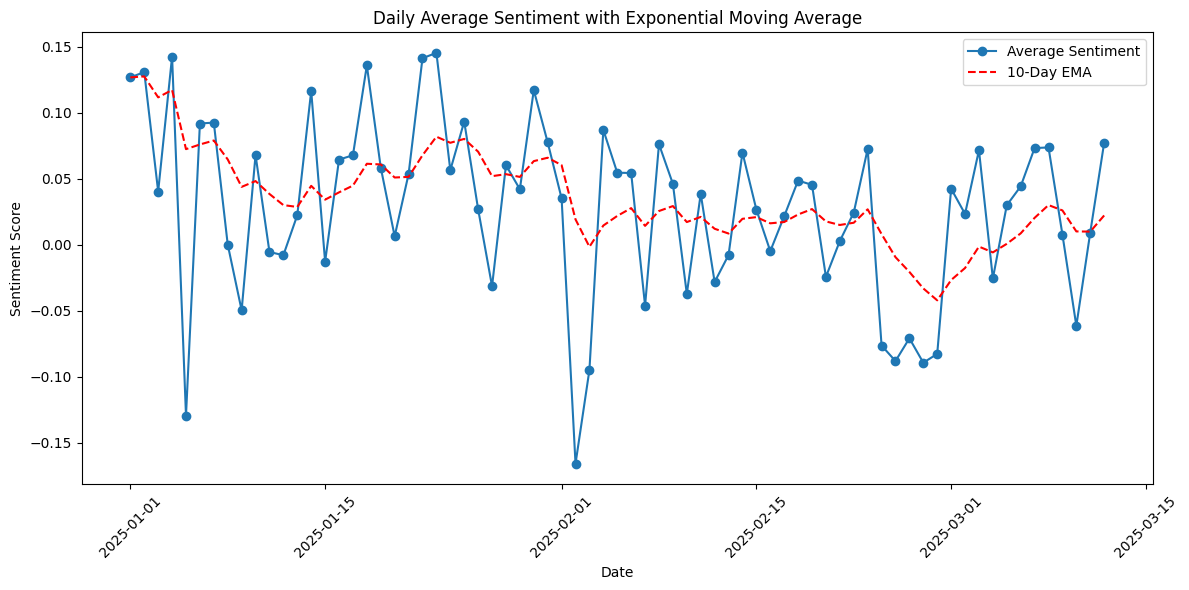

In [ ]:
# prompt: create a graph with an Exponential Moving Average for the 'Average Sentiment' column

import matplotlib.pyplot as plt

# Assuming 'daily_avg_sentiment' DataFrame is already created as in your code

def exponential_moving_average(data, window):
    """Calculates the exponential moving average."""
    ema = [data[0]]  # Initialize with the first value
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return ema

# Set the window size (adjust as needed)
window = 10  # Example: 5-day EMA
alpha = 2 / (window + 1)  # Calculate alpha

# Calculate EMA for 'Average Sentiment'
daily_avg_sentiment['EMA'] = exponential_moving_average(daily_avg_sentiment['Average Sentiment'], window)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_sentiment['date_published'], daily_avg_sentiment['Average Sentiment'], label='Average Sentiment', marker='o', linestyle='-')
plt.plot(daily_avg_sentiment['date_published'], daily_avg_sentiment['EMA'], label=f'{window}-Day EMA', color='red', linestyle='--')

# Customize the plot
plt.title('Daily Average Sentiment with Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files

# Save DataFrame to CSV
csv_filename = 'articles.csv'
df.to_csv(csv_filename, index=False)
print(f"CSV file with sentiment analysis and Bitcoin Adj Close data saved as: {csv_filename}")

files.download(csv_filename)

CSV file with sentiment analysis and Bitcoin Adj Close data saved as: articles.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

final_df_nonscaled=final_df_nonscaled.drop(['date_published'], axis=1)
print(final_df_nonscaled.columns)

Index(['Average Sentiment', 'BTC-USD_Open', 'BTC-USD_High', 'BTC-USD_Low',
       'BTC-USD_Close', 'BTC-USD_Adj_Close', 'BTC-USD_Volume',
       'ETH-USD_Adj_Close', '^IXIC_Adj_Close', '^DJI_Adj_Close',
       '^GSPC_Adj_Close', '^FTSE_Adj_Close', 'EURUSD=X_Adj_Close',
       'CNYUSD=X_Adj_Close', 'BZ=F_Adj_Close', 'RSI'],
      dtype='object')


In [ ]:


# Generate descriptive analysis table
descriptive_table = final_df_nonscaled.describe()

# Transpose the descriptive statistics table
descriptive_table = descriptive_table.T


descriptive_table['skewness'] = final_df_nonscaled.skew()
descriptive_table['kurtosis'] = final_df_nonscaled.kurtosis()

# Add a new column with variables
descriptive_table['variable'] = descriptive_table.index

# Reorder the columns
descriptive_table = descriptive_table[['variable', 'count', 'mean', 'std', 'min', 'max', 'skewness', 'kurtosis']]
# Print the descriptive analysis table
print("Descriptive Analysis Table:")
print(descriptive_table)

# Save DataFrame to CSV
csv_filename = 'Descriptive Analysis Table.csv'
descriptive_table.to_csv(csv_filename, index=False)
print(f"Descriptive Analysis Table saved as: {csv_filename}")

Descriptive Analysis Table:
                              variable   count          mean           std  \
Average Sentiment    Average Sentiment  1576.0  1.362144e-02  8.627318e-02   
BTC-USD_Open              BTC-USD_Open  1576.0  3.092852e+04  1.650245e+04   
BTC-USD_High              BTC-USD_High  1576.0  3.163379e+04  1.692999e+04   
BTC-USD_Low                BTC-USD_Low  1576.0  3.017567e+04  1.600719e+04   
BTC-USD_Close            BTC-USD_Close  1576.0  3.096186e+04  1.650859e+04   
BTC-USD_Adj_Close    BTC-USD_Adj_Close  1576.0  3.096186e+04  1.650859e+04   
BTC-USD_Volume          BTC-USD_Volume  1576.0  3.229265e+10  1.859641e+10   
ETH-USD_Adj_Close    ETH-USD_Adj_Close  1576.0  1.813090e+03  1.126241e+03   
^IXIC_Adj_Close        ^IXIC_Adj_Close  1576.0  1.268966e+04  2.063555e+03   
^DJI_Adj_Close          ^DJI_Adj_Close  1576.0  3.247983e+04  3.782635e+03   
^GSPC_Adj_Close        ^GSPC_Adj_Close  1576.0  4.046836e+03  5.760349e+02   
^FTSE_Adj_Close        ^FTSE_Adj_Clo

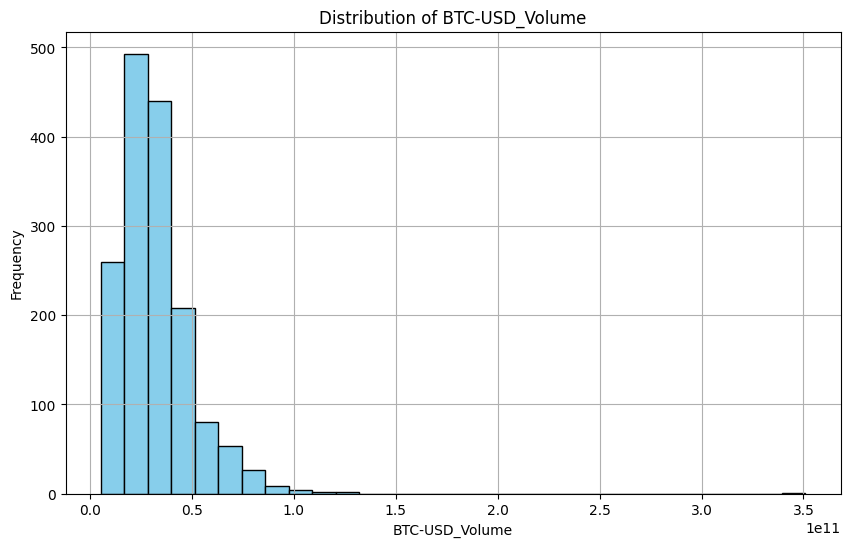

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of 'BTC-USD_Adj_Close'
plt.figure(figsize=(10, 6))
plt.hist(final_df_nonscaled['BTC-USD_Volume'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of BTC-USD_Volume')
plt.xlabel('BTC-USD_Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

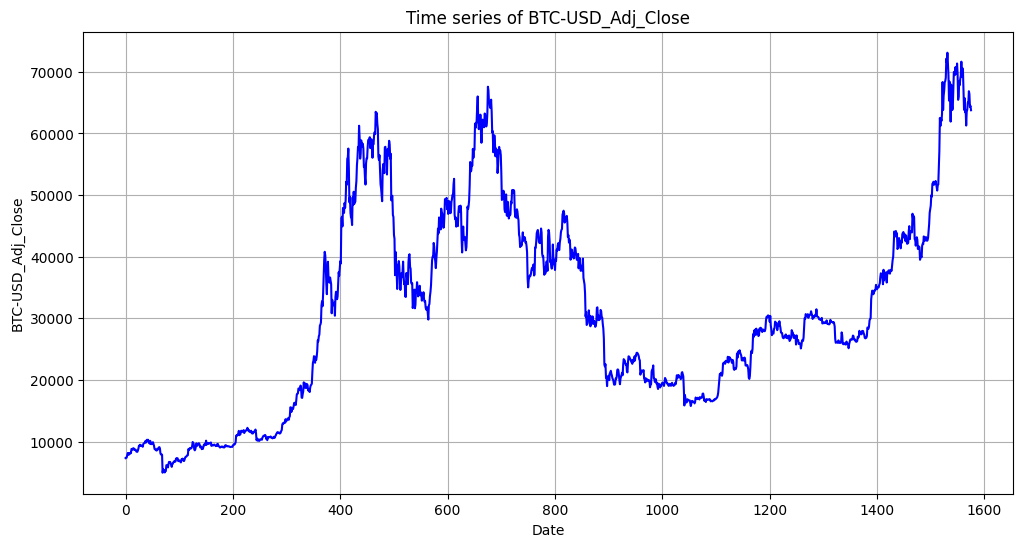

In [ ]:
import matplotlib.pyplot as plt

# Plot the time series of 'BTC-USD_Adj_Close'
plt.figure(figsize=(12, 6))
plt.plot(final_df_nonscaled.index, final_df_nonscaled['BTC-USD_Adj_Close'], color='blue')
plt.title('Time series of BTC-USD_Adj_Close')
plt.xlabel('Date')
plt.ylabel('BTC-USD_Adj_Close')
plt.grid(True)
plt.show()

In [ ]:
from google.colab import files

# Save DataFrame to CSV
csv_filename = 'Descriptive Analysis Table.csv'
descriptive_table.to_csv(csv_filename, index=False)
print(f"CSV file saved as: {csv_filename}")

# Download CSV file
files.download(csv_filename)

CSV file saved as: Descriptive Analysis Table.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(final_dataframe.columns)
hidden_nodes = int(2/3 * (1* num_of_features))
print(hidden_nodes)

Index(['Average Sentiment', 'BTC-USD_Open', 'BTC-USD_High', 'BTC-USD_Low',
       'BTC-USD_Adj_Close', 'BTC-USD_Volume', '^FTSE_Adj_Close',
       'EURUSD=X_Adj_Close', 'CNYUSD=X_Adj_Close', 'BZ=F_Adj_Close', 'RSI'],
      dtype='object')
7


Grid Search

In [ ]:
num_of_features = len(final_dataframe.columns)
print(num_of_features)

11


In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from itertools import product

from tensorflow.keras.optimizers import legacy

train_size_percent = 0.80
pred_col = final_dataframe.columns.get_loc('BTC-USD_Adj_Close')
look_back = 120
num_of_features = len(final_dataframe.columns)

# Define the initial learning rate
initial_learning_rate = 0.001

# Create an Adam optimizer with the specified learning rate (legacy version)
adam_optimizer = legacy.Adam(learning_rate=initial_learning_rate)

# Set random seed for TensorFlow operations
tf.random.set_seed(25)

# Define the initial learning rate
initial_learning_rate = 0.001

# Define hyperparameters to search over
lstm_layers_list = [32, 64, 128]
epochs_list = [100]
batch_size_list = [1, 32, 64, 128]

best_result = None
best_loss = float('inf')  # Define best_loss initially as positive infinity

# function to split the data
def create_dataset(final_dataframe, pred_col, look_back=1):
    dataX, dataY = [], []
    for i in range(len(final_dataframe) - look_back - 1):
        # Slice the dataframe to get the input sequence
        a = final_dataframe.iloc[i:(i+look_back), :]
        dataX.append(a.values)  # Convert the sliced dataframe to a numpy array
        # Append the target value to dataY
        dataY.append(final_dataframe.iloc[i + look_back, pred_col])
    return np.array(dataX), np.array(dataY)


train_size = int(len(final_dataframe) * train_size_percent)
test_size = len(final_dataframe) - train_size
train, test = final_dataframe[0:train_size], final_dataframe[train_size:len(final_dataframe)]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

# Iterate over all combinations of hyperparameters
for lstm_layers, epochs, batch_size in product(lstm_layers_list, epochs_list, batch_size_list):
    # create and compile the model
    model = Sequential()
    model.add(LSTM(lstm_layers, input_shape=(look_back, num_of_features)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=adam_optimizer)

    # Define early stopping criteria
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # fit the model
    history = model.fit(trainX, trainY, validation_split=0.30, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], shuffle=False, verbose=0)

    # evaluate the model
    loss = model.evaluate(testX, testY, verbose=0)

    # Check if the current result has the smallest loss
    if loss < best_loss:
        best_loss = loss
        best_result = {
            'lstm_layers': lstm_layers,
            'epochs': epochs,
            'batch_size': batch_size,
            'loss': loss
        }

# Print the best result
print("Best Result:")
print(best_result)

Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 9.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping


KeyboardInterrupt: 

In [ ]:
print(final_dataframe.columns)

final_dataframe6 = final_dataframe.drop(['EURUSD=X_Adj_Close', 'CNYUSD=X_Adj_Close'], axis=1)

print(final_dataframe6.columns)

Index(['Average Sentiment', 'BTC-USD_Open', 'BTC-USD_High', 'BTC-USD_Low',
       'BTC-USD_Adj_Close', 'BTC-USD_Volume', '^FTSE_Adj_Close',
       'EURUSD=X_Adj_Close', 'CNYUSD=X_Adj_Close', 'BZ=F_Adj_Close', 'RSI'],
      dtype='object')
Index(['Average Sentiment', 'BTC-USD_Open', 'BTC-USD_High', 'BTC-USD_Low',
       'BTC-USD_Adj_Close', 'BTC-USD_Volume', '^FTSE_Adj_Close',
       'BZ=F_Adj_Close', 'RSI'],
      dtype='object')


In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf

# Set random seed for TensorFlow operations
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()
# Set random seed for NumPy operations
np.random.seed(42)


# Define the initial learning rate
initial_learning_rate = 0.001

# Create an Adam optimizer with the specified learning rate
adam_optimizer = Adam(learning_rate=initial_learning_rate)


train_size_percent = 0.80
pred_col = final_dataframe6.columns.get_loc('BTC-USD_Adj_Close')
look_back = 120
num_of_features = len(final_dataframe6.columns)
lstm_layers = 128
epochs = 100
batch_size = 32

# function to split the data
def create_dataset(final_dataframe5, pred_col, look_back=1):
    dataX, dataY = [], []
    for i in range(len(final_dataframe5) - look_back - 1):
        # Slice the dataframe to get the input sequence
        a = final_dataframe5.iloc[i:(i+look_back), :]
        dataX.append(a.values)  # Convert the sliced dataframe to a numpy array
        # Append the target value to dataY
        dataY.append(final_dataframe5.iloc[i + look_back, pred_col])
    return np.array(dataX), np.array(dataY)


train_size = int(len(final_dataframe6) * train_size_percent)
test_size = len(final_dataframe6) - train_size
train, test = final_dataframe6[0:train_size], final_dataframe6[train_size:len(final_dataframe6)]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

print(trainX.shape)  # Check the shape of trainX after reshaping
print(testX.shape)   # Check the shape of testX after reshaping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
history= model.fit(trainX, trainY, validation_split=0.30, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], shuffle=False)

# Calculate the lengths of train, validation, and test sets
train_length = int(len(final_dataframe6) * train_size_percent)
validation_length = int(train_length * 0.30)  # 30% of the train set
test_length = len(final_dataframe6) - train_length

print('Train set length:', train_length)
print('Validation set length:', validation_length)
print('Test set length:', test_length)

Training dataset length  1260
Testing dataset length  316
look_back  120
(1139, 120, 9)
(195, 120, 9)
Epoch 1/100
25/25 [==============================] - 7s 161ms/step - loss: 0.0439 - val_loss: 0.0063
Epoch 2/100
25/25 [==============================] - 4s 173ms/step - loss: 0.0277 - val_loss: 0.0145
Epoch 3/100
25/25 [==============================] - 4s 175ms/step - loss: 0.0109 - val_loss: 0.0017
Epoch 4/100
25/25 [==============================] - 5s 184ms/step - loss: 0.0104 - val_loss: 7.2645e-04
Epoch 5/100
25/25 [==============================] - 3s 130ms/step - loss: 0.0097 - val_loss: 3.6351e-04
Epoch 6/100
25/25 [==============================] - 6s 250ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 7/100
25/25 [==============================] - 4s 146ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 8/100
25/25 [==============================] - 3s 140ms/step - loss: 0.0014 - val_loss: 8.2489e-04
Epoch 9/100
25/25 [==============================] - 5s 209ms/step - loss: 0.0

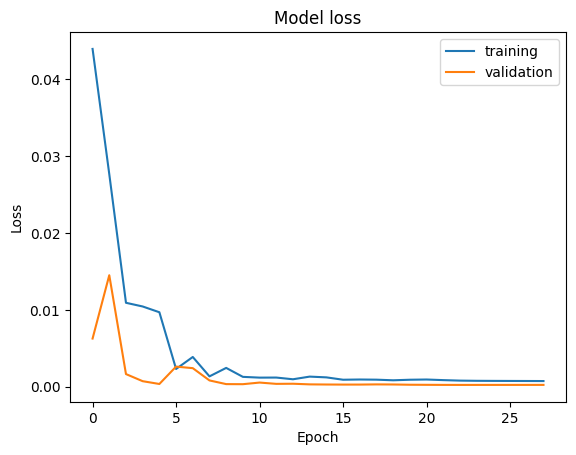

In [ ]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
print(trainX.shape)
print(testX.shape)

(981, 120, 11)
(352, 120, 11)


7/7 [==============================] - 0s 37ms/step


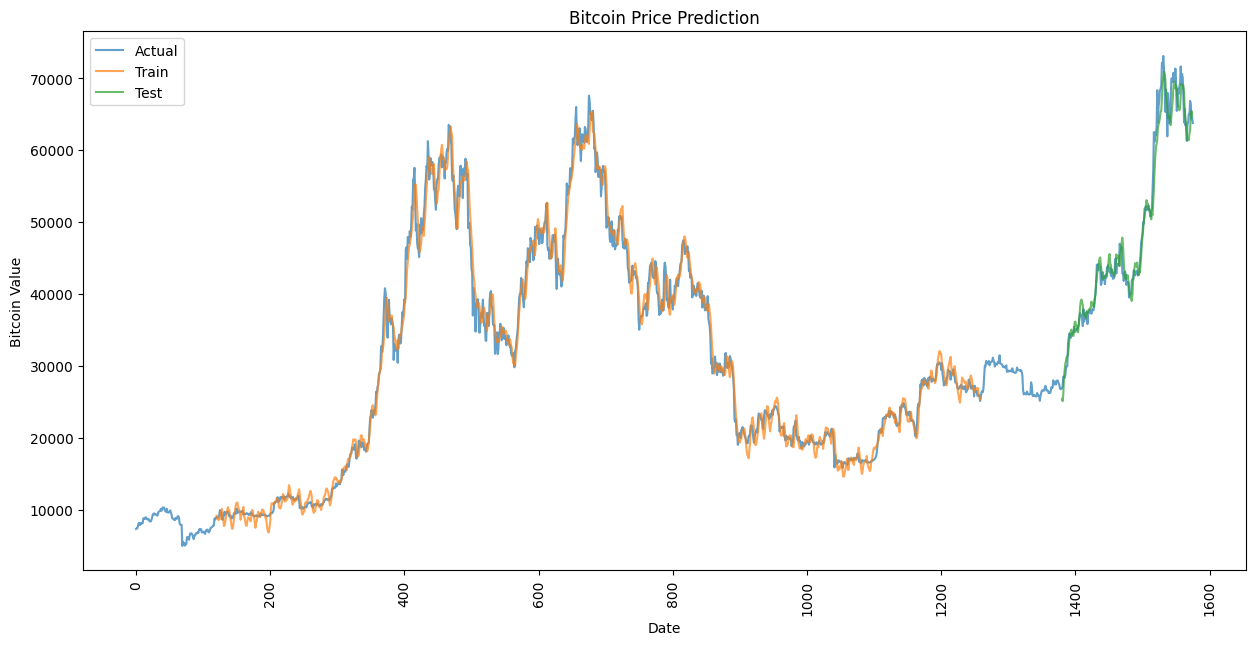

In [ ]:
# Extract only the 'BTC-USD_Adj_Close' column
btc_close_column = final_df_nonscaled['BTC-USD_Adj_Close']

# Reshape for compatibility with scaler
btc_close_column = btc_close_column.values.reshape(-1, 1)

# Scale the 'BTC-USD_Adj_Close' column
btc_close_scaled = scaler.fit_transform(btc_close_column)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
#trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]
# Inverse scale the predictions
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col]

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(final_dataframe6)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(final_dataframe6)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(final_dataframe6)-1, pred_col] = testPredict

time_df = pd.DataFrame(final_dataframe6.index, columns=['timestamp'])  # Assuming the index represents timestamps
time_df['Actual'] = scaler.inverse_transform(final_dataframe6)[:, pred_col]
df1 = pd.DataFrame(trainPredictPlot[:, pred_col], columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:, pred_col], columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('timestamp', inplace=True)

# Plot the output
fig, ax = plt.subplots(figsize=(15, 7))
time_df2.plot(ax=ax, rot=90, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.show()


In [ ]:
print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))


--------------------------------------------------
Train Score: 1671.92 RMSE
Test Score: 1965.33 RMSE
--------------------------------------------------
Train Score: 1215.23 MAE
Test Score: 1429.86 MAE


Model Summary

In [ ]:
expr_name = 'MODEL 5'
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(final_dataframe5.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: MODEL 5
--------------------------------------------------
look_back days: 120
lstm_layers: 128
epochs: 100
batch_size: 32
dataset features ['Average Sentiment', 'BTC-USD_Open', 'BTC-USD_High', 'BTC-USD_Low', 'BTC-USD_Adj_Close', 'BTC-USD_Volume', 'EURUSD=X_Adj_Close', 'CNYUSD=X_Adj_Close', 'BZ=F_Adj_Close', 'RSI']
--------------------------------------------------
Train Score: 2395.94 RMSE
Test Score: 6291.91 RMSE
--------------------------------------------------
Train Score: 1703.71 MAE
Test Score: 5396.81 MAE
--------------------------------------------------
Model summary:
Model: "sequential_156"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_156 (LSTM)             (None, 128)               71168     
                                                                 
 dense_156 (Dense)           (None, 1)                 129 